# First Assignment
## MSc course in Artificial Intelligence



In [ ]:
# Initially, we clone the course repository
!rm -rf AI_USI_MA
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

Cloning into 'AI_USI_MA'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 395 (delta 51), reused 97 (delta 24), pack-reused 265
Receiving objects: 100% (395/395), 13.91 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [ ]:
# Let's prepare the environment by importing necessary libraries.
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from time import time as t
import matplotlib.pyplot as plt

################################################
# Depending on your execution environment, the way you import the required module will differ.

# If you are running this script locally on your machine, use the following import:
# from IO_manager.io_tsp import TSP_Instance_Creator
# from solvers.local_search import TwoOpt
# from solvers.TSP_solver import Solver_TSP
# from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from solvers.constructive_algorithms import compute_length
# from solvers.local_search import TwoOpt
# from solvers.two_opt_with_candidate import twoOpt_with_cl

# However, if you are executing this notebook within Google Colab and the libraries are stored
# in a folder named 'AI_USI_MA', you should use the import statement below:
from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.TSP_solver import Solver_TSP
from AI_USI_MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from AI_USI_MA.solvers.constructive_algorithms import compute_length
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl




---
## Iterated Local Search (ILS) for the Traveling Salesman Problem (TSP)

The Iterated Local Search (ILS) is a metaheuristic that seeks to improve the quality of solutions by repeatedly applying a local search and introducing slight modifications (perturbations) to escape from local optima. This approach proves beneficial, especially for combinatorial problems like the Traveling Salesman Problem (TSP).

In this assignment, we will be focusing on solving the TSP using ILS for three benchmark instances:

1. **d198**: A standard instance known as 'd198.tsp' in TSP literature.
2. **pr439**: Another well-studied instance that will test the efficiency and efficacy of our ILS approach.
3. **u1060**: A relatively larger instance, serving as a comprehensive test for the scalability of our method.

Let's begin by loading and inspecting the 'd198.tsp' instance.


name: d198
nPoints: 198
best_sol: 15780.0


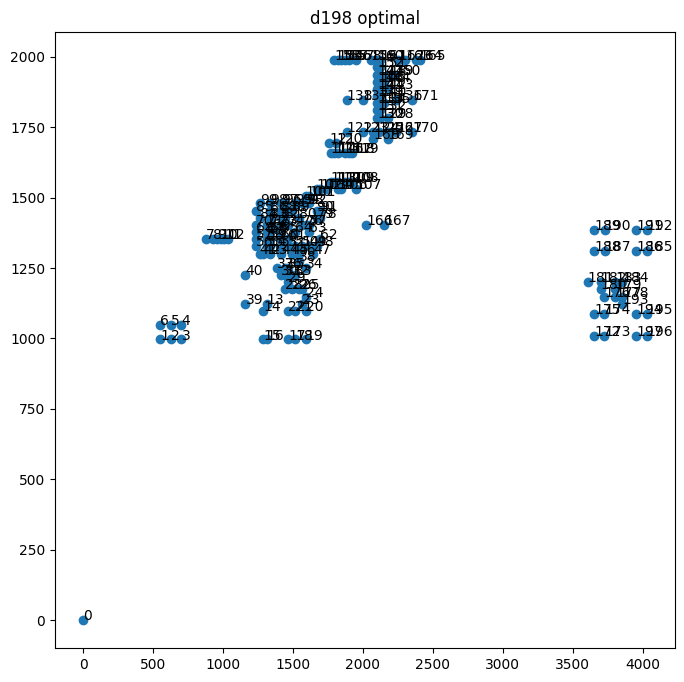

In [ ]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

---
## 2-opt Algorithm for TSP

The 2-opt algorithm is a renowned local search method, predominantly utilized for refining solutions in the Traveling Salesman Problem (TSP). At its core, the algorithm takes a route and systematically swaps pairs of cities to ascertain if the change results in a shorter tour.

In this notebook, we furnish a black-box version of the 2-opt. For those embarking on its usage for the first time, we suggest revisiting our ["Introduction to the TSP"](https://colab.research.google.com/github/UmbertoJr/AI_USI_MA/blob/master/introduction_to_the_TSP.ipynb#scrollTo=4aGR4Nus83wa). It's paramount that any meta-heuristic, including 2-opt, complies with the specific input and output conventions laid out in the primary notebook.

For a tangible example, glance over the **naive_heuristic**. Within, the `TwoOpt.local_search` method is invoked to iteratively enhance the TSP solution.

Two instrumental aspects to note in our design are:
1. The `yield` statement: Serving as a generator, it permits the algorithm to produce solutions in phases, thus allowing exploration of a plethora of potential solutions without exhaustive execution.
2. The `ending_cond` (Ending Condition): Crafted to ensure the TSP Solver either ceases after 3 minutes or concludes when the local search achieves an optimum state via the heuristic.

---


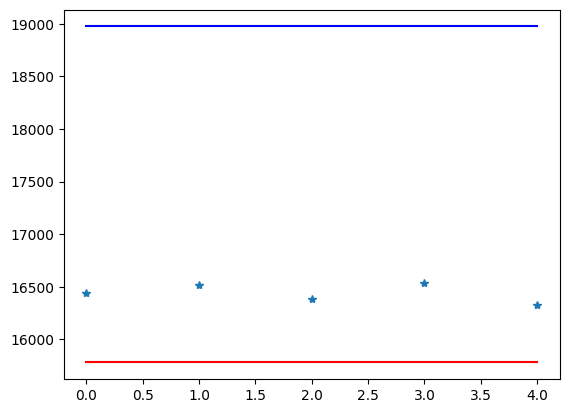

best gap with NN 20.25% on 1 trial,
with a total time of 0.004 seconds

best gap with random + 2opt 3.48% on 5 trials,
with a total time of 9.87 seconds


In [ ]:
def naive_heuristic(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    yield  new_solution, new_cost, number_calls_ls, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', Random_Initializer.random_method))
solver.bind(('naive heuristic', naive_heuristic ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', Nearest_Neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 trial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print()
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [ ]:
class DoubleBridge:
  def calculate_distance(distance_matrix, tour):
    total_distance = 0
    n = len(tour)

    for i in range(n - 1):
        # Assuming a distance matrix is available (distances between cities)
        # You may need to adapt this based on how your distances are represented.
        total_distance += distance_matrix[tour[i]][tour[i + 1]]

    # Add the distance from the last city back to the starting city
    total_distance += distance_matrix[tour[-1]][tour[0]]

    return total_distance

  @staticmethod
  def difference_cost(matrix, solution, new_solution):
    initial_cost = DoubleBridge.calculate_distance(matrix, solution)
    perturbed_cost = DoubleBridge.calculate_distance(matrix, new_solution)

    return perturbed_cost - initial_cost

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    a, b, c, d = sorted(np.random.choice(range(len(solution)), size=4, replace=False))

    # Apply the perturbation
    new_solution = np.concatenate((solution[:a], solution[c:d + 1], solution[b:c], solution[a:b], solution[d + 1:]))

    # Calculate the difference in cost
    delta_cost = DoubleBridge.difference_cost(matrix, solution, new_solution)

    new_actual_cost = actual_cost + delta_cost

    return new_solution, new_actual_cost


In [ ]:
# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 7.999447377877392
[ 0  1  6  7  8  9 10 11  3  4  5  2] 7.998578647186697


## Iterated Local Search


Here you need to implement the three variants of the ILS we saw earlier in class.

To boost the time performances please use the cython class **two_opt_with_candidate**.

In [ ]:
def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    if ending_cond == True:
      break
  return new_solution, new_cost

def generate_cl(dist_matrix):
  n = dist_matrix.shape[0]
  cl = np.zeros((n, 20))
  for i in range(n):
    cl[i] = np.argsort(dist_matrix[i, :])[1: 21]
  return cl

class ILS_Better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    #new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    cl = generate_cl(matrix)
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    best_sol, best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1
    while True:
        # Implement perturbation (e.g., DoubleBridge)
        perturbed_sol, perturbed_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)

        # Implement acceptance criterion (Better)
        if perturbed_cost < best_cost:
            best_sol, best_cost = perturbed_sol, perturbed_cost

        yield best_sol, best_cost, ls_calls, False

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    #new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    cl = generate_cl(matrix)
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1
    while True:
      # Implement perturbation (e.g., DoubleBridge)
      perturbed_sol, perturbed_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)

      # Implement acceptance criterion (RW)
      best_sol, best_cost = perturbed_sol, perturbed_cost

      yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    return np.exp((best_cost - new_cost) / temperature) > np.random.rand()

  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_LSMC
    #new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    cl = generate_cl(matrix)
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1
    temperature = 1.00  # Adjust this parameter based on the problem characteristics
    while True:
      # implement perturbation
      perturbed_sol, perturbed_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)

      # implement acceptance criterion
      if ILS_LSMC.acceptance_criterion(best_cost, perturbed_cost, temperature):
        best_sol, best_cost = perturbed_sol, perturbed_cost

      yield best_sol, best_cost, ls_calls, False

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task!

In [ ]:
seeds= [0, 123, 333]
time_to_solve = 180 # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"] #"d198.tsp", "pr439.tsp", "u1060.tsp"

initializers = ["random"]
init_functions = [Random_Initializer.random_method]

improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]

results = []
index = []
samples = {name: {improve: {seed: [] for seed in seeds} for improve in improvements} for name in names_instances}

for s_ in seeds:
  collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve][s_] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol)/instance.best_sol * 100, 2)
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

<ipython-input-137-ae661fe610d8>:58: RuntimeWarning: overflow encountered in exp
  return np.exp((best_cost - new_cost) / temperature) > np.random.rand()


,,,,tour length,gap,time to solve,calls Local Search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-better",0,22712.0,43.93,180.000,1
pr439.tsp,107217.0,"initialized with random, improved with ILS-better",0,174320.0,62.59,180.000,1
u1060.tsp,224094.0,"initialized with random, improved with ILS-better",0,357506.0,59.53,180.002,1
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,182446.0,1056.19,180.000,1
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,1942067.0,1711.34,180.001,1
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,6749649.0,2911.97,180.001,1
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,19778.0,25.34,180.000,1
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,218335.0,103.64,180.000,1
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,370959.0,65.54,180.001,1


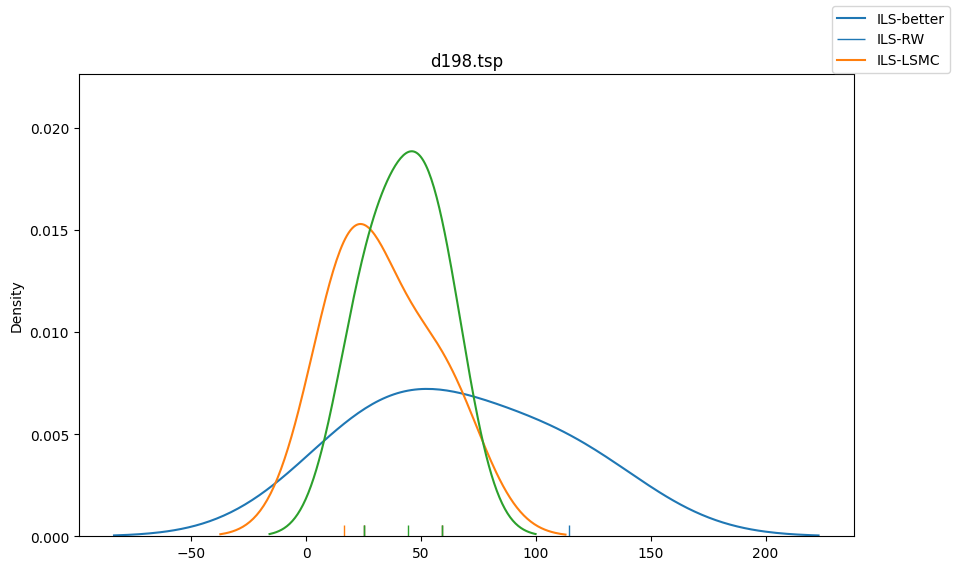

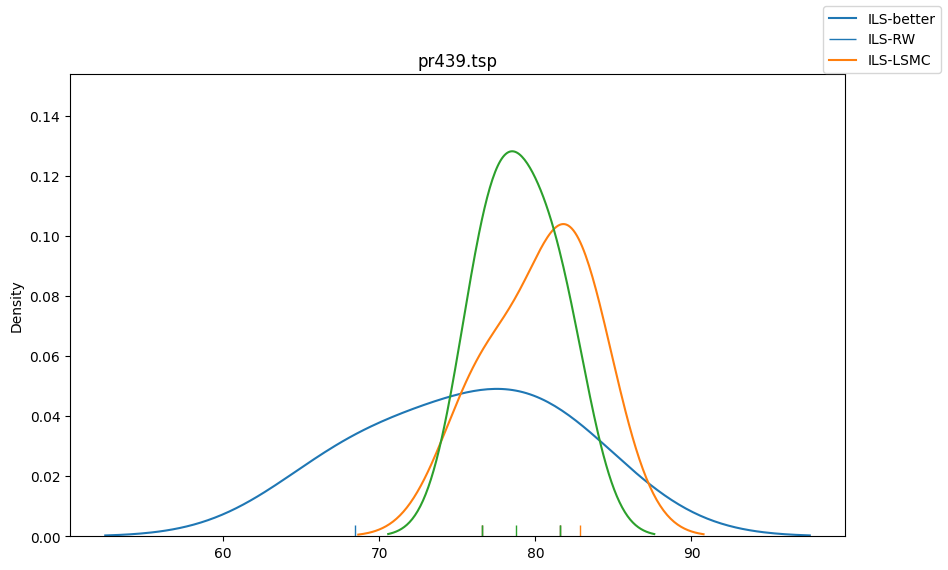

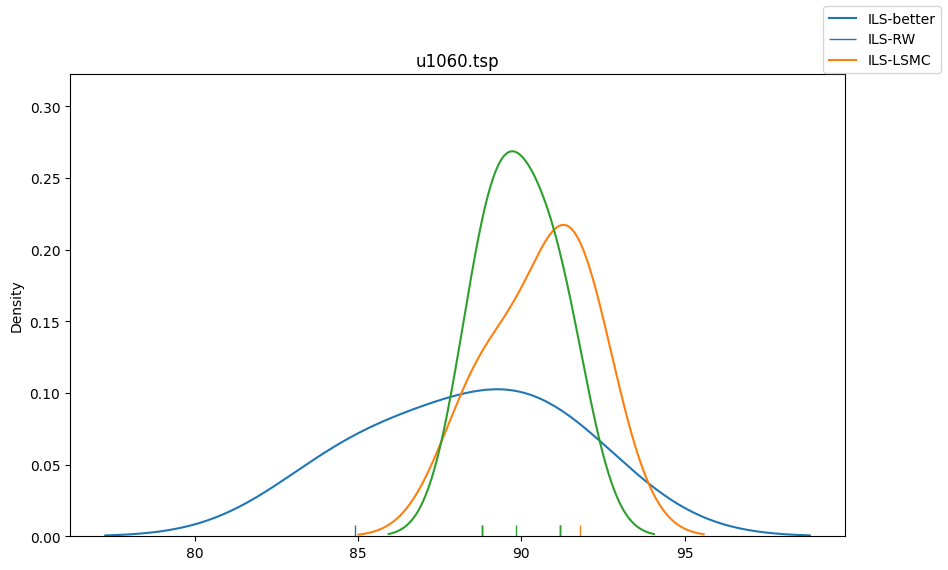

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      data = pd.DataFrame.from_dict(samples[instance][improve], orient='index').transpose()
      data_avg = data.mean(axis = 0, skipna = True)
      sns.distplot(data_avg, rug=True, hist=False)

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()

# Discussion:

*   **ILS-Better**: In general, ILS-Better generates solutions with gaps ranging from around 18.23% to 67.97%. The time limit for solving is 180 seconds. In some cases, the algorithm obtains quite small gaps. The number of calls to local search is always one, implying that the algorithm only makes one call to local search.
*   **ILS-RW**: The random walk version ILS-RW produces larger gaps, ranging up to 2931.28% for "u1060.tsp." This implies that, in contrast to ILS-Better, ILS-RW accepts any new solution, even if it is worse than the present one.
*   **ILS-LSMC**: Like ILS-Better, ILS-LSMC (Large Step Markov Chain) includes different gaps. Acceptance of novel solutions is probabilistic, with gaps ranging from around 19.45% to 103.64%.


# Overall Observations:

* ILS approaches, notably ILS-Better, show promise in obtaining reasonably narrow gaps in some cases.
* ILS-RW, like a random walk strategy, explores the search space more thoroughly, but at the expense of potentially accepting inferior answers.
* As observed in the results for the same instance, technique, and different seeds, performance might vary dramatically among different seeds.
